In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")

In [2]:
import os
import sys
import datetime
#import pprint
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import argmax
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K # beware of .python. here
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (BatchNormalization, Conv1D, Conv2D, Dense, 
                                     Flatten, Input, TimeDistributed, Activation, 
                                     Bidirectional, SimpleRNN, GRU, LSTM, Reshape)
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
!pip -q install watermark
import watermark
%load_ext watermark
%watermark --iversions

watermark        1.8.1
tensorflow.keras 2.2.4-tf
pandas           0.25.1
tensorflow       2.2.0-dev20200331
numpy            1.17.4
matplotlib       3.0.3
seaborn          0.9.0



In [4]:
df = pd.read_csv('fr_wiktionary_full.csv', sep='\t')
df = df[df.Audio != '-']
df[df.Mot.str.startswith('a')].head()

,Mot,Prononciation,H_aspiré,Type,Audio,Pré_valide,Warn_code,Warn_label
39093,a,a,False,pronom personnel,[],True,-,-
39094,a,a,False,lettre,[],True,-,-
39095,a,ɑ,False,lettre,[],True,-,-
39096,a,a,False,verbe_flexion,[],True,-,-
39097,a beau mentir qui vient de loin,a bo mɑ̃.tiʁ ki vjɛ̃ də lwɛ̃,False,locution-phrase,[],False,err_too_many_spaces,6_spaces


In [5]:
df.shape

(1503707, 8)

In [6]:
PHONEMES = [
        # Voyelles
        'i','e','ɛ','a','ɑ','ɔ','o','u','y','ø','œ','ə','ɛ̃','ɑ̃','ɔ̃','œ̃',
        # Semi-consonnes
        'j','w','ɥ', 
        # Consonnes
        'p','t','k','b','d','ɡ','f','s','ʃ','v','z','ʒ','l','ʁ','m','n','ɲ','ŋ',
    ]
    
def print_phonemes():
    i = 0 
    for i in range(len(PHONEMES) + 2):
        if i == 0:
            print("' 0")
        elif i == 1:
            print('<SPACE> 1')
        else:
            print('%s %d' % (PHONEMES[i-2], i))

In [7]:
# Skip samples whose pronunciation contains unknown phonemes
df = df[~df['Prononciation'].isin(PHONEMES)]

In [8]:
df.shape

(1503422, 8)

In [9]:
df.Prononciation.str.len().max()

120.0

In [10]:
df[df.Mot=='tonton']

,Mot,Prononciation,H_aspiré,Type,Audio,Pré_valide,Warn_code,Warn_label
1391761,tonton,tɔ̃.tɔ̃,False,nom,[],True,-,-


In [11]:
char_map_str = """
' 0
<SPACE> 1
i 2
e 3
ɛ 4
a 5
ɑ 6
ɔ 7
o 8
u 9
y 10
ø 11
œ 12
ə 13
ɛ̃ 14
ɑ̃ 15
ɔ̃ 16
œ̃ 17
j 18
w 19
ɥ 20
p 21
t 22
k 23
b 24
d 25
ɡ 26
f 27
s 28
ʃ 29
v 30
z 31
ʒ 32
l 33
ʁ 34
m 35
n 36
ɲ 37
ŋ 38
"""

char_map = {}
index_map = {}
for line in char_map_str.strip().split('\n'):
    ch, index = line.split()
    char_map[ch] = int(index)
    index_map[int(index)+1] = ch
index_map[2] = ' '

In [12]:
def get_phonemes(pronunciation):
    
    phonemes = []
    for i in range(len(pronunciation)):
        if i < len(pronunciation) - 1:
            if pronunciation[i]=='̃':
                continue
            if pronunciation[i+1]=='̃':
                if pronunciation[i] == 'ɑ':
                    phoneme = 'ɑ̃'
                elif pronunciation[i] == 'ɔ':
                    phoneme = 'ɔ̃'
                elif pronunciation[i] == 'œ':
                    phoneme = 'œ̃'
                elif pronunciation[i] == 'ɛ':
                    phoneme = 'ɛ̃'
                else:
                    print('can not happen c=%s' % c)
            else:
                phoneme = pronunciation[i]
        else:
            if pronunciation[i]=='̃':
                continue
            else: 
                phoneme = pronunciation[i]
        phonemes.append(phoneme)
    return phonemes

def get_padded_phonemes(pronunciation, str_len_max):
    
    padded_phonemes = get_phonemes(pronunciation)    
    # pad list of phonemes
    for i in range(len(padded_phonemes), str_len_max):
        padded_phonemes.append("'")
    return padded_phonemes

def get_tk_padded_phonemes(pronunciation, str_len_max):
    
    padded_phonemes = get_padded_phonemes(pronunciation, str_len_max)
    tk_padded_phonemes = []
    # tokenize each phoneme
    for phoneme in padded_phonemes:
        tk_padded_phonemes.append(char_map[phoneme])
    
    nb = len(padded_phonemes)
    np_array = np.array(tk_padded_phonemes).reshape(1, nb)
    
    return np_array
    
assert get_phonemes('tɛ̃bʁ') == ['t', 'ɛ̃', 'b', 'ʁ']
assert get_phonemes('tɔ̃tɔ̃') == ['t', 'ɔ̃', 't', 'ɔ̃']
assert get_padded_phonemes('tɛ̃bʁ', 6) == ['t', 'ɛ̃', 'b', 'ʁ', "'", "'"]
assert np.array_equal(get_tk_padded_phonemes('tɛ̃bʁ', 6), np.array([[22, 14, 24, 34,  0,  0]]))

def get_prononciation(padded_phonemes):
    
    prononciation = ''
    for padded_phoneme in padded_phonemes:
        if padded_phoneme == "'":
            break
        else:
            prononciation += padded_phoneme

    return prononciation
assert get_prononciation(['t', 'ɛ̃', 'b', 'ʁ', "'", "'"]) == 'tɛ̃bʁ', 6

In [13]:
def get_string_to_numpy(string, nb_max_chars):
    
    if nb_max_chars < len(string):
        raise ValueError('must not happen: nb_max_chars:%d too smal for string:%s (%d letters)'
             % (nb_max_chars, string, len(string)))
        return ''
    
    np_string = np.zeros((nb_max_chars))
    for i in range(len(string)):
        np_string[i] = ord(string[i])
        
    return np_string

def get_string_from_numpy(np_string):
    
    string=''
    for i in range(np_string.shape[0]):
        code = int(np_string[i])
        if code == 0:
            break
        else:
            string += chr(code)
    return string


assert get_string_from_numpy(get_string_to_numpy("tɛ̃bʁ", 6)) == "tɛ̃bʁ"

In [14]:
def get_audio_files_names(audio_files_str, locuteurs=[], verbose=False):
    if verbose:
        print('audio_files=*%s*' % audio_files_str)
    if audio_files_str == '[]':
        if verbose:
            print('empty list')
        audio_file_names = []
    else:
        if audio_files_str.startswith('['):
            files_string = audio_files_str[2:-2]
        else:
            files_string = audio_files_str
        files_string += '\', \''
        audio_file_names = files_string.split('\', \'')
        audio_file_names = audio_file_names[:-1]
        audio_file_names2 = []
        for audio_file_name in audio_file_names:
            if len(locuteurs) == 0:
                audio_file_names2.append(audio_file_name)
            else:
                for locuteur in locuteurs:         
                    if locuteur in audio_file_name:
                        audio_file_names2.append(audio_file_name)
        audio_file_names = audio_file_names2        
        if verbose:
            for f in audio_file_names:
                print('file=%s' % f)
    return audio_file_names

assert get_audio_files_names("[]") == []
assert get_audio_files_names("['a.wav']") == ['a.wav']
assert get_audio_files_names("LL-Q150 (fra)-LoquaxFR-&amp;.wav") == ['LL-Q150 (fra)-LoquaxFR-&amp;.wav']
assert get_audio_files_names("['a.wav', 'b.wav', 'c.wav']") == ['a.wav', 'b.wav', 'c.wav']
assert get_audio_files_names("['-foo-a.wav', '-bar-b.wav', '-car-c.wav', '-foo-d.wav']", ['foo']) == ['-foo-a.wav', '-foo-d.wav']
assert get_audio_files_names("['-foo-a.wav', '-bar-b.wav', '-car-c.wav', '-foo-d.wav']", ['bar']) == ['-bar-b.wav']
assert get_audio_files_names("['-foo-a.wav', '-bar-b.wav', '-car-c.wav', '-foo-d.wav']", ['bar', 'foo']) == ['-foo-a.wav', '-bar-b.wav', '-foo-d.wav']

In [15]:
AUDIO_DIR = 'audio/'
TIME_MAX = 2.0
MFCC_DIR = 'mfcc_' + str(TIME_MAX) + '/'

allowed_IPA_letters = [
            'a', 'b', 'd', 'e', 'f', 'i', 'j', 'k', 'l', 
            'm', 'n', 'o','p', 's', 't', 'u', 'v', 'w', 'y', 
            'z', 'ø', 'ŋ', 'œ', 'ɑ', 'ɔ', 'ə', 'ɛ', 'ɡ', 'ɥ',
            'ɲ', 'ʁ', 'ʃ', 'ʒ', '̃'   
]

''' Retrieve the dataset 
'''
def get_data(df, n_max=sys.maxsize, n_max_phonemes=sys.maxsize, locuteurs=[],
             verbose=False, order=True, check_phonemes=True):    
    
    df = pd.read_csv('fr_wiktionary_waves.csv', sep='\t')
    df = df[df.Audio != '-']
    
    df = df[df.Prononciation.str.len() <= n_max_phonemes]
    print('df.shape:%d (with len(prononciation)<=%d)' % (df.shape[0], n_max_phonemes))
    
    # filter out samples from selected locuteurs, if any
    df0 = pd.DataFrame(columns=df.columns)
    for locuteur in locuteurs:
        df0 = pd.concat([df0, df[df['Audio'].str.contains(locuteur)]])
    df = df0
    
    # reindex the dataframe by the Pronunciation column lenght
    if order:
        s = df.Prononciation.str.len().sort_values(ascending=True).index
        df = df.reindex(s)
        df = df.sample(frac=1).reset_index(drop=True)
    
    # clean pronunciation
    # rows having a pronnuciation with "bad" caracter will be dropped from the df
    if check_phonemes:
        indexes_to_drop = []
        bad_letters = {}   
        for index, row in df.iterrows():
            prononciation = row['Prononciation']
            prononciation = prononciation.replace('(','').replace(')','').replace('‿','').\
            replace('.','').replace(' ','').replace('͡','').replace('-','').replace('ˈ','').\
            replace('ː','').replace('r', 'ʁ')
            #prononciation = merge_nasals(prononciation)
            for phoneme in prononciation:            
                if phoneme not in allowed_IPA_letters:
                    if phoneme not in bad_letters.keys():
                        bad_letters[phoneme] = 0
                    bad_letters[phoneme] += 1
                    if verbose:
                        print('bad phoneme %s in [%s] /%s/' % (phoneme, row['Mot'], row['Prononciation']))
                    indexes_to_drop.append(index)
                    break
            df.at[index, 'Prononciation'] = prononciation            
        print('bad_letters=', bad_letters)
        df = df.drop(indexes_to_drop)
    
    # read 1 mfcc file to learn the maximum shape of the samples in the directory
    mfcc_shape_t = 0 #87
    mfcc_shape_d = 0 #40
    
    for index, row in df[df.Audio != '-'].iterrows():
       
        mfcc_file = ''
        wav_files = get_audio_files_names(row['Audio'])
        if verbose:
            print('Audio=*%s*' % row['Audio'])
        for wav_file in wav_files:
            if verbose:
                print('wav_file=*%s*' % wav_file)
            mfcc_file = wav_file.replace('.wav','.npy').replace(' ','_') 
            mfcc_filename = MFCC_DIR + mfcc_file
            if os.path.exists(mfcc_filename):
                mfcc = np.load(mfcc_filename)
                mfcc_shape_t = max(mfcc_shape_t, mfcc.shape[1])
                mfcc_shape_d = mfcc.shape[0]
                break
            else:
                if verbose:
                    print('mfcc_file=*%s* not found !!!' % mfcc_file)
    if mfcc_shape_t == 0:
        print('mfcc_shape_t not found !!!' % mfcc_file)
        return 0
    
    # mfcc_shape_t=87 # if time==2.0
    # mfcc_shape_d=40 #
    print('mfcc_shape_t:%d', mfcc_shape_t)
    print('mfcc_shape_d:%d', mfcc_shape_d)
    
    n_max = df.shape[0]
    n_ok=0
    n_ko=0
    
    # numpy shapes to be ready to be used as inputs and targets
    mfccs = np.zeros((n_max, mfcc_shape_t, mfcc_shape_d))
    phonemess = np.zeros((n_max, n_max_phonemes))
    CHAR_MAX = 50
    motss = np.zeros((n_max, CHAR_MAX))
    prononciationss = np.zeros((n_max, CHAR_MAX))
    #mots = []
    #prononciations = []
    
    for index, row in df.sample(n_max).iterrows(): # sample() is used to shuffle data           
    #for index, row in df.iterrows(): # sample() is used to shuffle data           
        
        mfcc_file = ''
        wav_files = get_audio_files_names(row['Audio'], locuteurs=locuteurs)
        # so far, take only first file (to be enhanced!!!)
        mfcc_file = wav_files[0].replace('.wav','.npy').replace(' ','_')
        
        if mfcc_file == '':
            continue
        
        mfcc_filename = MFCC_DIR + mfcc_file
        if os.path.exists(mfcc_filename):
            mfcc = np.load(mfcc_filename)
            if verbose:            
                print('mfcc.shape:', mfcc.shape)
            
            if mfcc[-1][-1] != 0.0:
                try:
                    if verbose:
                        print('pb for %s' % row['Mot'])
                except:
                    print('#')
                continue
            
            # add the mfcc in the mfccs table
            mfccs[n_ok,:,:] = mfcc.transpose()[:,:]
        
            # fetch the prononciation
            mot = row['Mot']
            prononciation = row['Prononciation']
            prononciation = prononciation.replace('(','').replace(')','').replace('‿','').\
            replace('.','').replace(' ','').replace('͡','').replace('-','').replace('ˈ','').\
            replace('ː','').replace('r', 'ʁ')
            
            phonemes = get_tk_padded_phonemes(prononciation, n_max_phonemes)
            
            # add the mfcc in the mfccs table
            phonemess[n_ok,:] = phonemes
            motss[n_ok:] = get_string_to_numpy(mot, CHAR_MAX)
            #mots.append(mot)
            #prononciations.append(prononciation)
            prononciationss[n_ok:] = get_string_to_numpy(prononciation, CHAR_MAX)
            n_ok += 1
            if n_ok > n_max - 1:
                break
        else:
            if verbose:
                print('file ko:', mfcc_file)
            n_ko += 1
            
    print('n_ok:',n_ok)
    print('n_ko:',n_ko)
    
    # delete unused rows
    mfccs = mfccs[:n_ok,:,:]
    phonemess = phonemess[:n_ok]
    prononciationss = prononciationss[:n_ok]
    motss = motss[:n_ok]
    
    print('mfccs.shape:', mfccs.shape)
    print('phonemess.shape:', phonemess.shape)
    print('prononciationss.shape:', prononciationss.shape)
    print('motss.shape:', motss.shape)
    #print('len(prononciations):', len(prononciations))
    #print('len(mots):', len(mots))
        
    return n_ok, mfccs, phonemess, prononciationss, motss

In [16]:
TARGET_PHONEMES_MAX = 20
locuteurs = ['WikiLucas'] # 19545 with TARGET_PHONEMES_MAX = 20
locuteurs = ['Lepticed'] #6145
locuteurs = ['WikiLucas', 'Lepticed'] # 25690
locuteurs = ['Lyokoï'] # 9039
locuteurs = ['WikiLucas', 'Lepticed','Lyokoï'] #

%time n, mfccs, phonemes, prononciations, mots = get_data(df, n_max=-1, n_max_phonemes=TARGET_PHONEMES_MAX, locuteurs = locuteurs)

df.shape:58761 (with len(prononciation)<=20)
bad_letters= {'h': 12, 'ʊ': 1, 'ʔ': 6, '·': 7, '…': 3, 'ɪ': 5, 'ε': 2, 'ˌ': 1, 'ʀ': 1, '/': 1, '̥': 3, '̩': 1, '̯': 2, ',': 2, 'ᵊ': 2, 'ʌ': 1, 'ɒ': 1, 'ʰ': 1, 'x': 1}
mfcc_shape_t:%d 87
mfcc_shape_d:%d 40
n_ok: 34729
n_ko: 54
mfccs.shape: (34729, 87, 40)
phonemess.shape: (34729, 20)
prononciationss.shape: (34729, 50)
motss.shape: (34729, 50)
CPU times: user 54 s, sys: 1.21 s, total: 55.2 s
Wall time: 55.2 s


In [17]:
NB_TEST_SAMPLES = 1000
print('NB_TEST_SAMPLES:%d' % NB_TEST_SAMPLES)

NB_TEST_SAMPLES:1000


In [18]:
phonemes.shape

(34729, 20)

In [19]:
mfccs.shape

(34729, 87, 40)

In [20]:
type(mfccs[0,0,0])

numpy.float64

In [21]:
n_wished_test = NB_TEST_SAMPLES
n_wished_train = n - n_wished_test
n_train_ratio = int(n_wished_train/n_wished_test)
print('n_train_ratio:%d',n_train_ratio)

# following code is somehow complex "just" to have the option to 
# preserve increased-length order in both the training and
# tests data.

# delete 1 row every n_train_ratio rows
mfccs_train = np.delete(mfccs, list(range(0, mfccs.shape[0], n_train_ratio)), axis=0)
phonemes_train = np.delete(phonemes, list(range(0, phonemes.shape[0], n_train_ratio)), axis=0)
prononciations_train = np.delete(prononciations, list(range(0, phonemes.shape[0], n_train_ratio)), axis=0)
mots_train = np.delete(mots, list(range(0, mots.shape[0], n_train_ratio)), axis=0)
X_train = mfccs_train
Y_train = phonemes_train

# keep 1 row every n_train_ratio
mfccs_test = mfccs[0::n_train_ratio]
phonemes_test = phonemes[0::n_train_ratio]
prononciations_test= prononciations[0::n_train_ratio]
mots_test = mots[0::n_train_ratio]
X_test = mfccs_test
Y_test = phonemes_test

n_train_ratio:%d 33


In [24]:
# get ride of few samples in order to respect the number of
# wanted test samples (e.g. decimal "round" number like 100)
# which will allow for direct estimation of percentages.
if mfccs_test.shape[0] - NB_TEST_SAMPLES > 0:
    mfccs_test = mfccs_train[0:NB_TEST_SAMPLES]
    phonemes_test = phonemes_train[0:NB_TEST_SAMPLES]
    mots_test = mots_test[0:NB_TEST_SAMPLES]
    X_test = mfccs_test
    Y_test = phonemes_test
NB_TRAINING_SAMPLES = X_train.shape[0]
print('NB_TRAINING_SAMPLES:%d' % NB_TRAINING_SAMPLES)
print('NB_TEST_SAMPLES:%d' % NB_TEST_SAMPLES)

NB_TRAINING_SAMPLES:33676
NB_TEST_SAMPLES:1000


In [25]:
x_train_mean = X_train.mean()
x_train_std = X_train.std()
X_train -= x_train_mean
X_train /= x_train_std

In [26]:
X_test -= x_train_mean
X_test /= x_train_std

In [27]:
# Actual loss calculation
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # From Keras example image_ocr.py:
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    #_pred = y_pred[:, 2:, :]
    y_pred = y_pred[:, :, :]
    #input_length = input_length[:,4:,:]
    #print(tf.shape(input_length))
    #print(tf.shape(input_length[0]))
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


# Update Input Lenght
def uil_lambda_func(args):
    
    input_length, kernel_size, conv_stride, conv_border_mode, dilation = args
    
    input_length = tf.dtypes.cast(input_length, tf.int32)
    kernel_size =  tf.dtypes.cast(kernel_size, tf.int32)
    conv_stride =  tf.dtypes.cast(conv_stride, tf.int32)
    
    
    res = (input_length - kernel_size + 1) // conv_stride
  
    res = tf.dtypes.cast(res, tf.int32) #+1 if stride bizarr
    
    return res


In [28]:
import math

def adjust_dimension(input_length, filter_size, stride, border_mode, dilation):

    new_dim = (input_length - filter_size + 1) / stride
    return int(new_dim)

#assert adjust_dimension(input_length=13, filter_size=6, stride=5, border_mode='valid', dilation=0) == 3

TD = adjust_dimension(input_length=40, filter_size=3, stride=2, border_mode='valid', dilation=0)
TD
#TD = adjust_dimension(input_length=TD, filter_size=3, stride=2, border_mode='valid', dilation=0)
TD
#adjust_dimension(input_length=44, filter_size=5, stride=2, border_mode='valid', dilation=0)
#TD = adjust_dimension(input_length=87, filter_size=3, stride=2, border_mode='same', dilation=0)
#TD

19

In [29]:
class AsrModel(object):

    # CTC Layer implementation using Lambda layer
    # (because Keras doesn't support extra params on loss function)
    def CTC(self, name, args):
        return Lambda(ctc_lambda_func, output_shape=(1,), name=name)(args)
 
    def UIL(self, name, args):
        return Lambda(uil_lambda_func, output_shape=(1,), name=name)(args)
 
    def __init__(self, D, max_string_len, C, T, conv = '1D'):
        print('D=%d, max_string_len=%d, C=%d' % (D, max_string_len, C))
           
        filters = 128
        units = 512
        kernel_size = 3
        kernel_size_2d = (kernel_size,kernel_size)
        conv_stride = 1 #3
        conv_border_mode = 'same'# same or valid
        dilation = 0
        
        if conv == '1D':
            self.input_data = Input(name='the_input', shape=(None, D), dtype='float32') #D=40
            
            self.conv_1d_01 = Conv1D(filters, kernel_size, 
                                        strides=conv_stride, 
                                        padding=conv_border_mode,
                                        activation='relu',
                                        name='conv_1d_01')(self.input_data)

            self.bn_01_layer = BatchNormalization(name='bn_01_layer')(self.conv_1d_01)

            self.conv_1d_02 = Conv1D(filters*2, kernel_size, 
                                        strides=conv_stride, 
                                        padding=conv_border_mode,
                                        activation='relu',
                                        name='conv_1d_02')(self.bn_01_layer)

            self.bn_02_layer = BatchNormalization(name='bn_02_layer')(self.conv_1d_02)

        elif conv == '2D':
            self.input_data = Input(name='the_input', shape=(T, D, 1), dtype='float32') #D=40
        
            self.conv_2d_00 = Conv2D(units, kernel_size_2d, 
                                        strides=conv_stride, 
                                        padding=conv_border_mode,
                                        activation='relu',
                                        name='conv_2d_00')(self.input_data)
            
            self.bn_00_layer = BatchNormalization(name='bn_00_layer')(self.conv_2d_00)
            
            self.conv_2d_01 = Conv2D(units*2, kernel_size_2d, 
                                        strides=conv_stride, 
                                        padding=conv_border_mode,
                                        activation='relu',
                                        name='conv_2d_01')(self.bn_00_layer)

            self.bn_01_layer = BatchNormalization(name='bn_01_layer')(self.conv_2d_01)

            self.conv_2d_02 = Conv2D(units*4, kernel_size_2d, 
                                        strides=conv_stride, 
                                        padding=conv_border_mode,
                                        activation='relu',
                                        name='conv_2d_02')(self.bn_01_layer)
            
            self.bn_03_layer = BatchNormalization(name='bn_03_layer')(self.conv_2d_02)

            self.bnf_0_layer = Flatten()(self.bn_03_layer)        
            self.bnrf_0_layer = Reshape((-1, 3*9))(self.bnf_0_layer)
            self.bn_02_layer = TimeDistributed(Dense(3*9), name="bn_02_layer")(self.bnrf_0_layer)
            
        else:
            print('conv_type=%s not supported' % conv_type)
            
        rnn0 = keras.layers.LSTM(units, return_sequences=True, dropout=0.5, name="rnn")
        self.bidir_rnn1 = Bidirectional(rnn0, name='bidir_rnn_1_layer')(self.bn_02_layer)
        
        self.bn_1 = BatchNormalization(name='bn_1_layer')(self.bidir_rnn1)
        
        rnn = keras.layers.LSTM(units, return_sequences=True, dropout=0.5, name="rnn2")
        self.bidir_rnn2 = Bidirectional(rnn, name='bidir_rnn_2_layer')(self.bn_1)
        
        self.bn_2 = BatchNormalization(name='bn_2_layer')(self.bidir_rnn2)
        
        self.outputs = TimeDistributed(Dense(C), name="td")(self.bn_2)
        
        self.y_pred = Activation('softmax', name='softmax')(self.outputs)

        self.labels = Input(name='the_labels', shape=[max_string_len], dtype='float32')
        self.input_length = Input(name='input_length', shape=[1], dtype='int64')
        self.label_length = Input(name='label_length', shape=[1], dtype='int64')
        
        #self.input_length2 = Input(name='input_length2', shape=[1], dtype='int64')
        #self.input_length3 = Input(name='input_length3', shape=[1], dtype='int64')
        
        
        #self.input_length2 = self.UIL('uil', [self.input_length, kernel_size, conv_stride, conv_border_mode, dilation])
        #self.input_length3 = self.UIL('uil', [self.input_length2, kernel_size, conv_stride, conv_border_mode, dilation])
        
        self.loss_out = self.CTC('ctc', [self.y_pred, self.labels, self.input_length, self.label_length])

        self.model = Model(inputs=[self.input_data, self.labels, self.input_length, self.label_length], 
                           outputs=self.loss_out)

            
        #self.model.ouput_length = lambda x: cnn_output_length(x, kernel_size, conv_border_mode, conv_stride)
        
        self.model.summary()

        #adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        adam = Adam()
        self.model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=adam)

    def fit(self, X_train, Y_train, input_length, label_length, loss, epochs, 
            batch_size, callbacks, validation_split, verbose):
        print("input_length=",input_length)
        history = self.model.fit([X_train, Y_train, input_length, label_length], loss, 
                                 epochs=epochs, batch_size=batch_size, 
                                 callbacks=callbacks,
                                 validation_split=validation_split, verbose=verbose, )
        return history 
      
    def predict(self, input_batch):
        return self.test_function([input_batch, True])[0]  # the first 0 indicates test

    @property
    def test_function(self):
        # captures output of softmax so we can decode the output during visualization
        #return K.function([self.input_data, K.symbolic_learning_phase()], [self.y_pred, K.symbolic_learning_phase()])
        return K.function([self.input_data, K.symbolic_learning_phase()], [self.y_pred, K.symbolic_learning_phase()])

In [30]:
# outputs = {'ctc': np.zeros([size])}  # dummy data for dummy loss function
#input_length = X_train.shape[1]
#print('input_length', input_length)

print('X_train.shape', X_train.shape)
print('Y_train.shape', Y_train.shape)
      
N = NB_TRAINING_SAMPLES
print('N:%d (Number of samples)', N)
T = mfccs.shape[1]
print('T:%d (Time units)', T)
D = mfccs.shape[2]
print('D:%d (Data units (frequency samples))', D)

input_length = np.zeros([N])
for i in range(N):
    input_length[i] = 87
print('input_length[0:2]:', input_length[0:2])
print('input_length.shape', input_length.shape)

label_length = np.zeros([N])
for i in range(N):
    label_length[i] = TARGET_PHONEMES_MAX
print('label_length[0:2]:', label_length[0:2])

#print('input_length.shape', input_length.shape)

loss = np.zeros([N])

print('loss.shape[0:2]', loss.shape[0:2])


C = len(char_map.keys()) + 1
print('C=%d (Classes units (IPA char samples)' % C)

X_train.shape (33676, 87, 40)
Y_train.shape (33676, 20)
N:%d (Number of samples) 33676
T:%d (Time units) 87
D:%d (Data units (frequency samples)) 40
input_length[0:2]: [87. 87.]
input_length.shape (33676,)
label_length[0:2]: [20. 20.]
loss.shape[0:2] (33676,)
C=40 (Classes units (IPA char samples)


In [31]:
model = AsrModel(D, TARGET_PHONEMES_MAX, C, T)

D=40, max_string_len=20, C=40
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          [(None, None, 40)]   0                                            
__________________________________________________________________________________________________
conv_1d_01 (Conv1D)             (None, None, 128)    15488       the_input[0][0]                  
__________________________________________________________________________________________________
bn_01_layer (BatchNormalization (None, None, 128)    512         conv_1d_01[0][0]                 
__________________________________________________________________________________________________
conv_1d_02 (Conv1D)             (None, None, 256)    98560       bn_01_layer[0][0]                
________________________________________________________________

In [32]:
print('X_train.shape', X_train.shape)

X_train.shape (33676, 87, 40)


In [33]:
callbacks_list = [
        EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=10,
            restore_best_weights=True,
        ),
    ]

In [34]:
history = model.fit(X_train, Y_train, input_length, label_length, loss, 
                    epochs=200, batch_size=32, callbacks=callbacks_list, 
                    validation_split=0.1, verbose=True)

input_length= [87. 87. 87. ... 87. 87. 87.]
Epoch 1/200
948/948 [==============================] - 58s 61ms/step - loss: 20.8568 - val_loss: 11.2357
Epoch 2/200
948/948 [==============================] - 58s 61ms/step - loss: 9.2314 - val_loss: 7.5170
Epoch 3/200
948/948 [==============================] - 57s 60ms/step - loss: 6.6034 - val_loss: 5.7577
Epoch 4/200
948/948 [==============================] - 56s 59ms/step - loss: 4.9613 - val_loss: 4.5509
Epoch 5/200
948/948 [==============================] - 57s 60ms/step - loss: 4.1630 - val_loss: 4.0528
Epoch 6/200
948/948 [==============================] - 58s 61ms/step - loss: 3.7708 - val_loss: 4.0172
Epoch 7/200
948/948 [==============================] - 58s 61ms/step - loss: 3.5262 - val_loss: 3.7502
Epoch 8/200
948/948 [==============================] - 58s 61ms/step - loss: 3.2711 - val_loss: 3.5273
Epoch 9/200
948/948 [==============================] - 58s 61ms/step - loss: 3.0642 - val_loss: 3.3410
Epoch 10/200
948/948 [=====

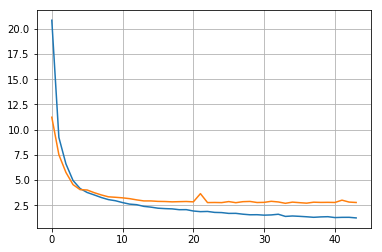

In [35]:
_ = plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.show()

In [36]:
X_test.shape

(1053, 87, 40)

In [50]:
# test NB_TEST_SAMPLES samples
res = model.predict(X_test[0:NB_TEST_SAMPLES])

In [51]:
res.shape

(1000, 87, 40)

In [52]:
s = K.ctc_decode(y_pred=res, input_length=input_length[0:res.shape[0]], greedy=True)
#print(s)

In [53]:
from IPython.display import Markdown
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

n_tested = 0
n_ok = 0
n_ko = 0
results = np.asarray(s[0][0])
debug_str = '[MOT] /PRONONCIATION WIKTIONNAIRE/ vs /PRONONCIATION PREDITE/<br>'

targets = []
predictions = []

for i in range(NB_TEST_SAMPLES):
    if i%10 != 0:
        continue
    phonemes = ''
    mot = get_string_from_numpy(mots_test[i])
    prononciation = get_string_from_numpy(prononciations_test[i])
    #prononciation = phonemes_test[i]
    
    debug_str += '[' + mot + '] /' + prononciation + '/ vs '
    for letter in range(results.shape[1]):
        val = results[i, letter]
        if val == -1:
            continue
        phoneme = index_map[val+1]
        #print('r=',results[n,letter],end=',')
        phonemes += phoneme
    phonemes = phonemes.replace("\'",'')
    targets.append(prononciation)
    predictions.append(phonemes)
    debug_str += '/' + phonemes + '/'
    n_tested += 1
    if phonemes == prononciation:
        debug_str += ': <span style="color: #00ff00">ok</span><br>'
        n_ok += 1
    else:
        debug_str += ': <span style="color: #ff0000">ko</span><br>'  
        n_ko += 1
display (Markdown(debug_str))
        
print('n_tested:%d, n_ok:%d, n_ko:%d' % (n_tested, n_ok, n_ko))

[MOT] /PRONONCIATION WIKTIONNAIRE/ vs /PRONONCIATION PREDITE/<br>[incirconspection] /ɛ̃siʁkɔ̃spɛksjɔ̃/ vs /ɛ̃siʁkɔ̃spɛksjɔ̃/: <span style="color: #00ff00">ok</span><br>[Ville-Mariste] /vilmaʁist/ vs /vilmaʁist/: <span style="color: #00ff00">ok</span><br>[carnipain] /kaʁnipɛ̃/ vs /kaʁnipɛ̃/: <span style="color: #00ff00">ok</span><br>[traînailler] /tʁɛnɑje/ vs /tʁɛnaje/: <span style="color: #ff0000">ko</span><br>[bouillait] /bujɛ/ vs /bujɛ/: <span style="color: #00ff00">ok</span><br>[cryoturbation] /kʁijɔtyʁbasjɔ̃/ vs /kʁiʁʒɔʁpasjɔ̃/: <span style="color: #ff0000">ko</span><br>[cramponnement] /kʁɑ̃pɔnmɑ̃/ vs /kʁɑ̃vɔnmɑ̃/: <span style="color: #ff0000">ko</span><br>[mormonisme] /mɔʁmɔnism/ vs /mɔʁmɔnism/: <span style="color: #00ff00">ok</span><br>[dallasser] /dalase/ vs /dalase/: <span style="color: #00ff00">ok</span><br>[probation] /pʁɔbasjɔ̃/ vs /pʁɔbasjɔ̃/: <span style="color: #00ff00">ok</span><br>[vedettisme] /vədɛtizm/ vs /vədɛtism/: <span style="color: #ff0000">ko</span><br>[précautionneusement] /pʁekɔsjɔnøzmɑ̃/ vs /pʁekɔsjɔnøzmɑ̃/: <span style="color: #00ff00">ok</span><br>[choc thermique] /ʃɔktɛʁmik/ vs /fɔtɛʁmik/: <span style="color: #ff0000">ko</span><br>[mazzinien] /mazinjɛ̃/ vs /madziɲɛ̃/: <span style="color: #ff0000">ko</span><br>[avoir des couilles] /avwaʁdekuj/ vs /avwaʁdekuj/: <span style="color: #00ff00">ok</span><br>[s’esquiver] /sɛskive/ vs /sɛskive/: <span style="color: #00ff00">ok</span><br>[mendélisme] /mɛ̃delism/ vs /mɑ̃delism/: <span style="color: #ff0000">ko</span><br>[dalle] /dal/ vs /dal/: <span style="color: #00ff00">ok</span><br>[empanner] /ɑ̃pane/ vs /ɑ̃pane/: <span style="color: #00ff00">ok</span><br>[NO] /nɔʁwɛst/ vs /nɔʁwɛst/: <span style="color: #00ff00">ok</span><br>[marboulette] /maʁbulɛt/ vs /maʁbulɛt/: <span style="color: #00ff00">ok</span><br>[histogramme] /istoɡʁam/ vs /istɔɡʁam/: <span style="color: #ff0000">ko</span><br>[saumâtriseriez] /somɑtʁizəʁje/ vs /somɑtʁizəʁje/: <span style="color: #00ff00">ok</span><br>[trâlée] /tʁɑle/ vs /tʁale/: <span style="color: #ff0000">ko</span><br>[bavoter] /bavɔte/ vs /bavɔte/: <span style="color: #00ff00">ok</span><br>[sirop de cordum] /siʁodəkoʁdɔm/ vs /siʁɔdəkɔʁdɔm/: <span style="color: #ff0000">ko</span><br>[ne pas fermer l’œil] /nəpafɛʁmelœj/ vs /nəpaʁɛmelœj/: <span style="color: #ff0000">ko</span><br>[présentiste] /pʁezɑ̃tist/ vs /pʁezɑ̃tist/: <span style="color: #00ff00">ok</span><br>[chaououal] /ʃauwal/ vs /ʃawal/: <span style="color: #ff0000">ko</span><br>[olim] /olim/ vs /œlim/: <span style="color: #ff0000">ko</span><br>[voyez-vous ça] /vwajevusa/ vs /vwajevusa/: <span style="color: #00ff00">ok</span><br>[perdre son sang froid] /pɛʁdʁəsɔ̃sɑ̃fʁwa/ vs /pɛʁdʁsɔ̃sɑ̃fʁwa/: <span style="color: #ff0000">ko</span><br>[prosaïser] /pʁɔzaize/ vs /pʁozajize/: <span style="color: #ff0000">ko</span><br>[abolissable] /abɔlisabl/ vs /abɔlisabl/: <span style="color: #00ff00">ok</span><br>[bavasser] /bavase/ vs /bavase/: <span style="color: #00ff00">ok</span><br>[prendre pour une bille] /pʁɑ̃dʁpuʁynbij/ vs /pʁɑ̃dʁəpuʁynbij/: <span style="color: #ff0000">ko</span><br>[écrouler] /ekʁule/ vs /ekʁule/: <span style="color: #00ff00">ok</span><br>[abattit] /abati/ vs /abati/: <span style="color: #00ff00">ok</span><br>[perpétration] /pɛʁpetʁasjɔ̃/ vs /pɛʁtetʁasjɔ̃/: <span style="color: #ff0000">ko</span><br>[avoir tout faux] /avwaʁtufo/ vs /avwaʁtufo/: <span style="color: #00ff00">ok</span><br>[emmotter] /ɑ̃mɔte/ vs /ɑ̃mɔte/: <span style="color: #00ff00">ok</span><br>[blackliste] /blaklist/ vs /blaklist/: <span style="color: #00ff00">ok</span><br>[islamiste] /islamist/ vs /islamist/: <span style="color: #00ff00">ok</span><br>[belgo-allemand] /bɛlɡoalmɑ̃/ vs /bɛlɡɔɛləmɑ̃/: <span style="color: #ff0000">ko</span><br>[rebattre les oreilles] /ʁəbatʁlezɔʁɛj/ vs /ʁəbaʁlezɔʁɛj/: <span style="color: #ff0000">ko</span><br>[abat-carrâmes] /abakaʁam/ vs /abakaʁam/: <span style="color: #00ff00">ok</span><br>[aller à la malle] /alealamal/ vs /alealamal/: <span style="color: #00ff00">ok</span><br>[pare-brise] /paʁbʁiz/ vs /paʁbʁiz/: <span style="color: #00ff00">ok</span><br>[processus léger] /pʁɔsesysleʒe/ vs /pʁɔsesysleʒe/: <span style="color: #00ff00">ok</span><br>[co-tourner] /kotuʁne/ vs /kotuʁne/: <span style="color: #00ff00">ok</span><br>[rerembrayer] /ʁəʁɑ̃bʁeje/ vs /ʁəʁɑ̃ɡʁɛje/: <span style="color: #ff0000">ko</span><br>[caisse claire] /kɛsklɛʁ/ vs /kɛsklɛʁ/: <span style="color: #00ff00">ok</span><br>[encapsulation] /ɑ̃kapsylasjɔ̃/ vs /ɑ̃kapsylasjɔ̃/: <span style="color: #00ff00">ok</span><br>[bucheronner] /byʃʁɔne/ vs /byʃʁɔne/: <span style="color: #00ff00">ok</span><br>[redoubler] /ʁəduble/ vs /ʁəduble/: <span style="color: #00ff00">ok</span><br>[référentiel] /ʁefeʁɑ̃sjɛl/ vs /ʁefeʁɑ̃sjɛl/: <span style="color: #00ff00">ok</span><br>[croître en sagesse] /kʁwatʁɑ̃saʒɛs/ vs /kʁwatʁɑ̃saʒɛs/: <span style="color: #00ff00">ok</span><br>[émouvoir] /emuvwaʁ/ vs /emuvwaʁ/: <span style="color: #00ff00">ok</span><br>[donner à cens] /dɔneasɑ̃s/ vs /dɔneasɑ̃s/: <span style="color: #00ff00">ok</span><br>[lapinisme] /lapinism/ vs /lapinism/: <span style="color: #00ff00">ok</span><br>[ménager le terrain] /menaʒelətɛʁɛ̃/ vs /menaʒelatɛʁɛ̃/: <span style="color: #ff0000">ko</span><br>[hypertaxation] /ipɛʁtaksasjɔ̃/ vs /ipɛʁtɛksasjɔ̃/: <span style="color: #ff0000">ko</span><br>[GDM] /ʒedeɛm/ vs /ʒedeɛm/: <span style="color: #00ff00">ok</span><br>[calcination] /kalsinasjɔ̃/ vs /kalisinasjɔ̃/: <span style="color: #ff0000">ko</span><br>[arc adjacent] /aʁkadʒasɑ̃/ vs /aʁkadʒasɑ̃/: <span style="color: #00ff00">ok</span><br>[longuement] /lɔ̃ɡmɑ̃/ vs /lɔ̃dmɑ̃/: <span style="color: #ff0000">ko</span><br>[carte mère] /kaʁtəmɛʁ/ vs /kaʁtmɛʁ/: <span style="color: #ff0000">ko</span><br>[branduit] /bʁɑ̃dyi/ vs /bʁɑ̃dɥi/: <span style="color: #ff0000">ko</span><br>[bankable] /bɑ̃kabl/ vs /bɑ̃kebl/: <span style="color: #ff0000">ko</span><br>[suavement] /sɥavmɑ̃/ vs /sɥavmɑ̃/: <span style="color: #00ff00">ok</span><br>[ré-établir] /ʁeetabliʁ/ vs /ʁeetabliʁ/: <span style="color: #00ff00">ok</span><br>[purgeuse] /pyʁʒøz/ vs /pyʁʒø/: <span style="color: #ff0000">ko</span><br>[s’emboucaner] /sɑ̃bukane/ vs /sɑ̃bukane/: <span style="color: #00ff00">ok</span><br>[flatteusement] /flatœzəmɑ̃/ vs /latøzmɑ̃/: <span style="color: #ff0000">ko</span><br>[perroqueter] /pɛʁɔkəte/ vs /pɛʁɔkəte/: <span style="color: #00ff00">ok</span><br>[samos] /samos/ vs /samos/: <span style="color: #00ff00">ok</span><br>[prototrophie] /pʁototʁɔfi/ vs /pʁɔpɔtʁɔfi/: <span style="color: #ff0000">ko</span><br>[faire les boutiques] /fɛʁlebutik/ vs /fɛʁlɛbutik/: <span style="color: #ff0000">ko</span><br>[hongrer] /ɔ̃ɡʁe/ vs /ɔ̃ɡʁe/: <span style="color: #00ff00">ok</span><br>[polylogisme] /pɔlilɔʒism/ vs /pɔlilɔʒism/: <span style="color: #00ff00">ok</span><br>[diallèle] /djalɛl/ vs /djalɛl/: <span style="color: #00ff00">ok</span><br>[agis] /aʒi/ vs /aʒi/: <span style="color: #00ff00">ok</span><br>[autoavorter] /otoavɔʁte/ vs /otoavɔʁte/: <span style="color: #00ff00">ok</span><br>[networker] /nɛtwɔʁke/ vs /nɛtwaʁke/: <span style="color: #ff0000">ko</span><br>[rebisquer] /ʁəbiske/ vs /ʁəbiske/: <span style="color: #00ff00">ok</span><br>[difforme] /difɔʁm/ vs /difɔʁm/: <span style="color: #00ff00">ok</span><br>[trousseau] /tʁuso/ vs /tʁbuso/: <span style="color: #ff0000">ko</span><br>[mécatronique] /mekatʁɔnik/ vs /mekatʁɔnik/: <span style="color: #00ff00">ok</span><br>[arraisonner] /aʁɛzɔne/ vs /aʁɛzɔne/: <span style="color: #00ff00">ok</span><br>[anglophile] /ɑ̃ɡlɔfil/ vs /ɑ̃ɡlɔfil/: <span style="color: #00ff00">ok</span><br>[aboutissant] /abutisɑ̃/ vs /abutisɑ̃/: <span style="color: #00ff00">ok</span><br>[faire bisquer] /fɛʁbiske/ vs /fɛʁbiske/: <span style="color: #00ff00">ok</span><br>[décafarad] /dekafaʁad/ vs /dekafaʁad/: <span style="color: #00ff00">ok</span><br>[jusqu’auboutiste] /ʒyskobutist/ vs /ʒyskobutist/: <span style="color: #00ff00">ok</span><br>[créationniste] /kʁeasjɔnist/ vs /kʁeasjɔnist/: <span style="color: #00ff00">ok</span><br>[expiation] /ɛkspjasjɔ̃/ vs /ɛkspliasjɔ̃/: <span style="color: #ff0000">ko</span><br>[place du mort] /plasdymɔʁ/ vs /plasdymɔʁ/: <span style="color: #00ff00">ok</span><br>[lambdatiser] /lɑ̃bdatize/ vs /lɑ̃ddatize/: <span style="color: #ff0000">ko</span><br>[thalidomide] /talidɔmid/ vs /kalidɔmid/: <span style="color: #ff0000">ko</span><br>[frinault] /fʁino/ vs /fʁino/: <span style="color: #00ff00">ok</span><br>

n_tested:100, n_ok:64, n_ko:36


<Figure size 1008x720 with 0 Axes>

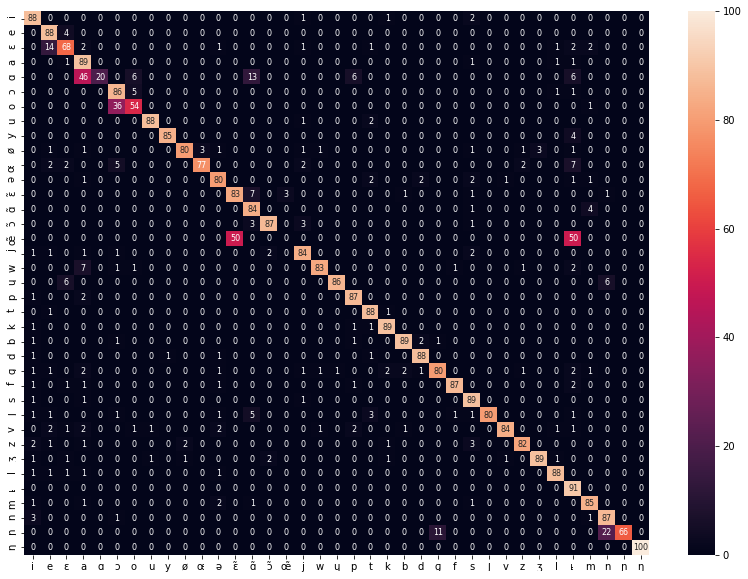

In [41]:
# create a copy of char_map without \' and <SPACE>
char_map2 = char_map.copy()
del char_map2["'"]
del char_map2["<SPACE>"]

# fill a confusion matrix 
confusion_array = np.zeros((len(char_map),len(char_map)))
for i in range(len(targets)):
    target_phonemes = get_phonemes(targets[i])
    prediction_phonemes = get_phonemes(predictions[i])
    for j in range(len(target_phonemes)):
        letter_targeted = target_phonemes[j]
        if j < len(prediction_phonemes):
            letter_predicted = prediction_phonemes[j]
            letter_targeted_index = char_map[letter_targeted]
            letter_predicted_index = char_map[letter_predicted]
            try:
                confusion_array[letter_targeted_index, letter_predicted_index] += 1
            except:
                print('error target letter:%s (%s), prediction:%s, predicted letter (in %s)' %\
                (letter_targeted, targets[i], letter_predicted, predictions[i]))

for t in range(confusion_array.shape[0]):
    sum = 0
    for p in range(confusion_array.shape[1]):
        sum += confusion_array[t, p]
    for p in range(confusion_array.shape[1]):
        if sum > 0:
            confusion_array[t, p] = int(confusion_array[t, p]/sum*100)
            
# display the confusion matrix
# create a copy of char map without first two chars (' and SPACE)
char_map2 = char_map.copy()
del char_map2["'"]
del char_map2["<SPACE>"]
# display the confusion matrix without first 2 rows and first 2 colums
df_cm = pd.DataFrame(confusion_array[2:,2:], index = [i for i in char_map2],
                  columns = [i for i in char_map2])
plt.figure(figsize = (14,10))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}, fmt='g')
plt.show()